# Predicting US Airline Passenger Satisfaction Based on Various Features

In [3]:
import pandas as pd
import pandera as pa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV

## Summary
This project aims to create a robust predictive model of US airline customer satisfaction. Understanding customer satisfaction is very important for airlines as it provides directions to improve the service and equipment. The dataset contains a variety of flight information and a target variable indicating if the customer was satisfied or not. After proper processing and predictive modeling with algorithms like Logistic Regression and Decision Trees, we produced a reliable model that can predict customer satisfaction with 95% accuracy (given the necessary flight information). The results are quite impressive, as they provide very high performance indicating ability to distinguish between satisfied and unsatisfied customers.

## Introduction

In the highly competitive field of air transport management, passenger satisfaction plays a critical role in making customer loyalty, providing operational insights, enhancing financial performance, and ensuring compliance with regulations and rankings (Sadegh Eshaghi et al, 2024). While there are numerous studies held on factors influencing customer satisfaction like service quality (Namukasa, 2023), it is very important to be able to predict the customer satisfaction with high accuracy for understanding how to improve and make better decisions. In this study, we aim to create a reliable predictive model that will predict US airline passenger satisfaction with high performance.

## Methods

### Data
The dataset contains a variety of features from passengers’ flight experiences, including:

- **Demographic data** (e.g., age, gender)
- **Flight details** (e.g., flight distance, time of day)
- **Service-related features** (e.g., quality of meal, seat comfort, check-in process)

The data was pre-processed by:

- Removing unnecessary columns,
- Scaling numerical features using StandardScaler,
- Encoding categorical features using OneHotEncoder (ignoring unknown categories),
- Scaling ordinal features using MinMaxScaler.
  
This data was sourced from Kaggle and can be found from [here](https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction?select=train.csv). We use Pandas library for storing and manipulating the dataset (McKinney, 2010).

### Model
We used the following three models to predict customer satisfaction from the given attributes:
- Dummy Classifier (serving as a baseline)
- Logistic Regression
- Decision Trees

We use K-Fold cross-validation for finding the best performing model.

Additionally, we perform a hyperparameter tuning to decrease overfitting and get a more reliable model.

### Evaluation Metric
We used different evaluation metrics to have proper evaluation of the model performance. The metrics include accuracy, weighted recall, weighted precision and F1-Score.


## Data Validation

##### Data validation checklist
- [x] Correct data file format
- [x] Correct column names
- [x] No empty observations
- [x] Missingness not beyond expected threshold
- [x] Correct data types in each column
- [x] No duplicate observations
- [x] No outlier or anomalous values
- [x] Correct category levels (i.e., no string mismatches or single values)
- [x] Target/response variable follows expected distribution
- [x] No anomalous correlations between target/response variable and features/explanatory variables
- [x] No anomalous correlations between features/explanatory variables

#### Correct Data File Format

In [4]:
# Load the dataset
# 1. Correct data file format (.csv) compatible with Python
train_data = pd.read_csv('../data/train.csv', index_col='Unnamed: 0')
test_data = pd.read_csv('../data/test.csv', index_col='Unnamed: 0')

In [5]:
print("The shape of the training data is:", train_data.shape)
print("The shape of the test data is:", test_data.shape)

The shape of the training data is: (103904, 24)
The shape of the test data is: (25976, 24)


In [6]:
combined_dataset = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)
print("The shape of the combined data is:", combined_dataset.shape)
assert len(combined_dataset) == (len(train_data) + len(test_data)), "Combined dataset length should equal the length of the train and test datasets"

The shape of the combined data is: (129880, 24)


#### Correct Column Names

In [7]:
# Column names
print(f"\033[1mData columns:\033[0m {list(combined_dataset.columns)}")

Data columns: ['id', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'satisfaction']


In [8]:
def clean_column_names(df):
    """
    Clean column names by converting them to lowercase, replacing spaces and dashes with underscores. 
    
    Parameters:
    df (pd.DataFrame): The input pandas DataFrame whose column names need to be cleaned.

    Returns:
    pd.DataFrame: A DataFrame with cleaned column names.
    """
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(r'\s+', '_', regex=True)
    df.columns = df.columns.str.replace(r'-', '_', regex=True)
    df = df.rename({"departure/arrival_time_convenient":"time_convenient"}, axis=1)
    
    return df

In [9]:
# Clean column names
combined_dataset = clean_column_names(combined_dataset)

In [10]:
print(f"\033[1mCleaned data columns:\033[0m {list(combined_dataset.columns)}")

Cleaned data columns: ['id', 'gender', 'customer_type', 'age', 'type_of_travel', 'class', 'flight_distance', 'inflight_wifi_service', 'time_convenient', 'ease_of_online_booking', 'gate_location', 'food_and_drink', 'online_boarding', 'seat_comfort', 'inflight_entertainment', 'on_board_service', 'leg_room_service', 'baggage_handling', 'checkin_service', 'inflight_service', 'cleanliness', 'departure_delay_in_minutes', 'arrival_delay_in_minutes', 'satisfaction']


#### Empty Observations, Missingness, Correct Data Types, Outlier and Anomalous Values, Correct Category Levels

In [11]:
# Basic overview of the dataset
print(combined_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          129880 non-null  int64  
 1   gender                      129880 non-null  object 
 2   customer_type               129880 non-null  object 
 3   age                         129880 non-null  int64  
 4   type_of_travel              129880 non-null  object 
 5   class                       129880 non-null  object 
 6   flight_distance             129880 non-null  int64  
 7   inflight_wifi_service       129880 non-null  int64  
 8   time_convenient             129880 non-null  int64  
 9   ease_of_online_booking      129880 non-null  int64  
 10  gate_location               129880 non-null  int64  
 11  food_and_drink              129880 non-null  int64  
 12  online_boarding             129880 non-null  int64  
 13  seat_comfort  

In [12]:
# Data Validation Panderas Schema
missing_data_threshold = 0.05

schema = pa.DataFrameSchema(
    {
        "gender": pa.Column(str, pa.Check.isin(["Male", "Female"]), nullable=False),
        "customer_type": pa.Column(str, pa.Check.isin(["Loyal Customer", "Disloyal Customer"]), nullable=False),
        "age": pa.Column(int, pa.Check.between(0, 100), nullable=False),
        "type_of_travel": pa.Column(str, pa.Check.isin(["Business travel", "Personal Travel"]), nullable=False),
        "class": pa.Column(str, pa.Check.isin(["Eco", "Eco Plus", "Business"]), nullable=False),
        "flight_distance": pa.Column(int, pa.Check.greater_than(0), nullable=False),
        "inflight_wifi_service": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "time_convenient": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "ease_of_online_booking": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "gate_location": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "food_and_drink": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "online_boarding": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "seat_comfort": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "inflight_entertainment": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "on_board_service": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "leg_room_service": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "baggage_handling": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "checkin_service": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "inflight_service": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "cleanliness": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "departure_delay_in_minutes": pa.Column(int, pa.Check.greater_than_or_equal_to(0), nullable=True),
        "arrival_delay_in_minutes": pa.Column(float, pa.Check.greater_than_or_equal_to(0), nullable=True),
        "satisfaction": pa.Column(str, pa.Check.isin(["neutral or dissatisfied", "satisfied"]), nullable=False),
    },
    checks=[
        pa.Check(lambda df: ~(df.isna().all(axis=1)).any(), error="Empty rows found."),
        pa.Check(lambda df: (df.isna().sum() / len(df) < missing_data_threshold).all(), error=f"Some columns have more than {missing_data_threshold*100}% missing values.")
    ])

In [13]:
# Validate the dataset
# Customer Type column's values were not homogeneous, so we changed disloyal Customer -> Disloyal Customer
combined_dataset["customer_type"] = combined_dataset["customer_type"].str.title()

try:
    schema.validate(combined_dataset, lazy=True)
    print("Data validation passed.")
except pa.errors.SchemaErrors as e:
    print(e.failure_cases)

Data validation passed.


#### Checking Duplicates

Duplicates should be checked for both train and test sets. ID column is the unique identifier of both train and test datasets. If there are at least two ID's that are the same in the combined dataset, then we have duplicates.

In [14]:
# Combine the ids from both datasets
all_ids = combined_dataset.id

In [15]:
# Check if the length of the set of combined ids is the same as the length of the list of combined ids (set will drop the duplicates)
if (len(set(all_ids)) == len(all_ids)):
    print("No duplicates found")
else:
    print("There are duplicate observations")

No duplicates found


#### Further Duplicate Check

Another hypothesis is that we may have duplicate observations with different ID. 

In [16]:
print(f"Number of duplicated observations = {combined_dataset.drop('id', axis=1).duplicated().sum()}")

Number of duplicated observations = 0


#### Target Variable Analysis

Understanding the distribution of the target variable is crucial for understanding the problem type and guiding our approach.  

* Examine the data type of the target variable
* Visualize the target variable's distribution 

We start off by viewing the first few columns of the target variable

In [17]:
combined_dataset['satisfaction'].head()

0    neutral or dissatisfied
1    neutral or dissatisfied
2                  satisfied
3    neutral or dissatisfied
4                  satisfied
Name: satisfaction, dtype: object

It seems to contain text data(characters) we can confirm that by viewing the data type, and the unique groups, if any, in the data.

In [18]:
print(f"The data type for the target column is {combined_dataset['satisfaction'].dtype}")

The data type for the target column is object


In [19]:
print(f"The target variable 'satisfaction' consists of {combined_dataset['satisfaction'].nunique()} unique categories, {' and '.join(combined_dataset['satisfaction'].unique())}")

The target variable 'satisfaction' consists of 2 unique categories, neutral or dissatisfied and satisfied


The target variable is a text data with 2 distinct categories.

To get a better idea of the target variable we plot the distribution of the class below.

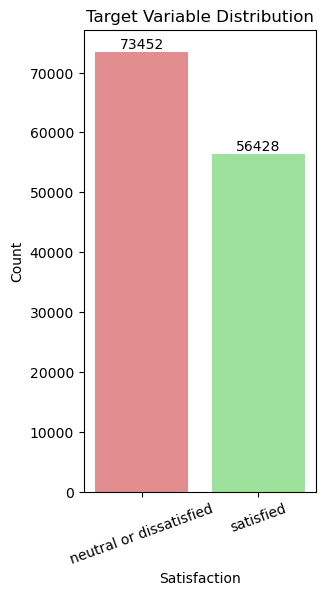

In [20]:
plt.figure(figsize=(3, 6))
ax = sns.countplot(data=combined_dataset, x = "satisfaction", hue="satisfaction", palette=["lightcoral", "lightgreen"], legend=False)
plt.title("Target Variable Distribution")
plt.xlabel("Satisfaction")
plt.ylabel("Count")
plt.xticks(rotation=20)
for p in ax.patches:
    height = p.get_height()  
    ax.text(p.get_x() + p.get_width() / 2, height + 0.1,  
            f'{int(height)}', 
            ha='center', va='bottom', fontsize=10)
plt.show()

In [21]:
combined_dataset['satisfaction'].value_counts(normalize=True)

satisfaction
neutral or dissatisfied    0.565537
satisfied                  0.434463
Name: proportion, dtype: float64

There are slightly more `neutral or dissatisfied` observations than there are `satisfied` observations. Overall, we can assume the distribution is close to balanced.

#### Correlations between target and exploratory variables

This check is done using the training dataset later in the Exploratory Data Analysis (EDA).

## Data Splitting

While the dataset was initially splitted, we don't know how good and reliable is the split. To be sure the dataset is randomly splitted, we perform the train-test split ourselves.

In [22]:
# Perform train test split
test_size = 0.2
random_state = 123
train_data, test_data = train_test_split(combined_dataset, test_size = test_size, random_state = random_state)

In [23]:
print(f"The train data shape: {train_data.shape}")
print(f"The test data shape: {test_data.shape}")

The train data shape: (103904, 24)
The test data shape: (25976, 24)


## EDA
For an exploratory data analysis (EDA) on the Airline Passenger Satisfaction dataset, the goal is to better understand the structure of the dataset, identify potential issues, and uncover insights about the factors that might influence passenger satisfaction.


### Understanding the Dataset
- Univariate analysis of the variables in the dataset.
- Checking correlations among variables.

### Target Variable Distribution

To see that there are enough observations from each class in both train and test set, we look at the target variable distribution of the train set as well.

In [24]:
train_data['satisfaction'].value_counts(normalize=True)

satisfaction
neutral or dissatisfied    0.564338
satisfied                  0.435662
Name: proportion, dtype: float64

The numbers are very similar to the full dataset numbers, so we can assume test dataset also contains enough observations from each class.

### Distribution of Numerical Variables
Plot histograms or boxplots for all numerical features to check their distribution and identify any outliers.

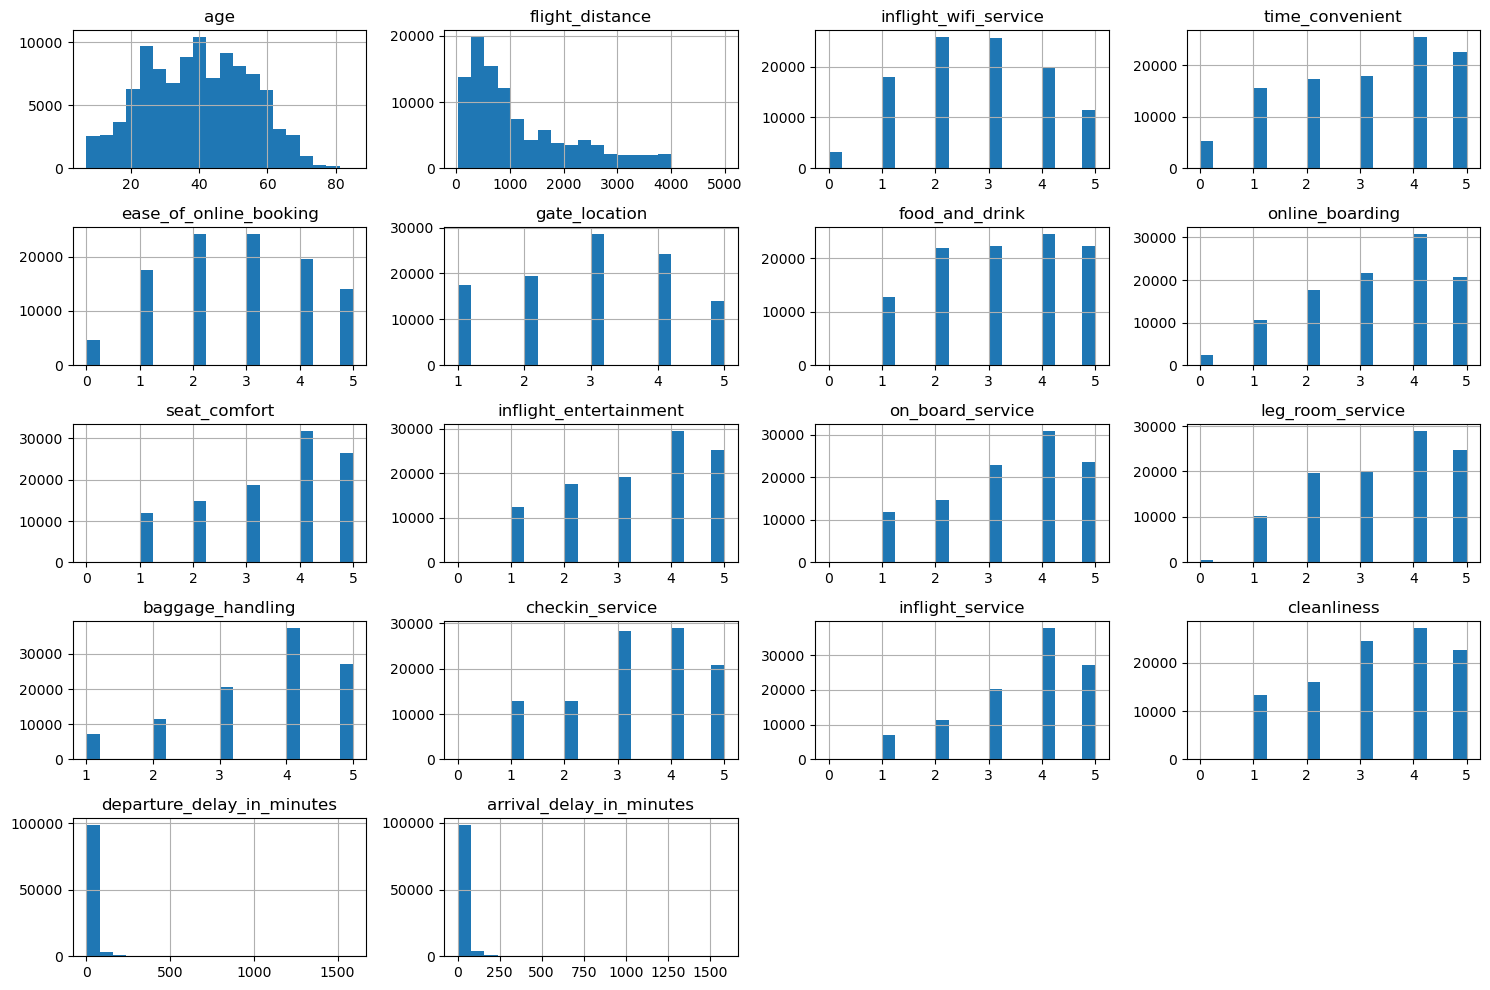

In [25]:
# Drop the id column
train_data = train_data.drop(['id'], axis=1)

# Histograms for numerical features
train_data.hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()

The numeric variables except `age` are mostly right skewed. So, most of them are not close to normal distribution.

Additionally, for some ordinal categorical variables like `seat_comfort`, `on_board_service` and `inflight_entertainment` there are very little observations having value of 0. We may need to handle those observations later.

### Correlation Between Features
- Check how numerical features correlate with each other, and see if there are any strong correlations. This can be done using a correlation matrix and visualized with a heatmap.

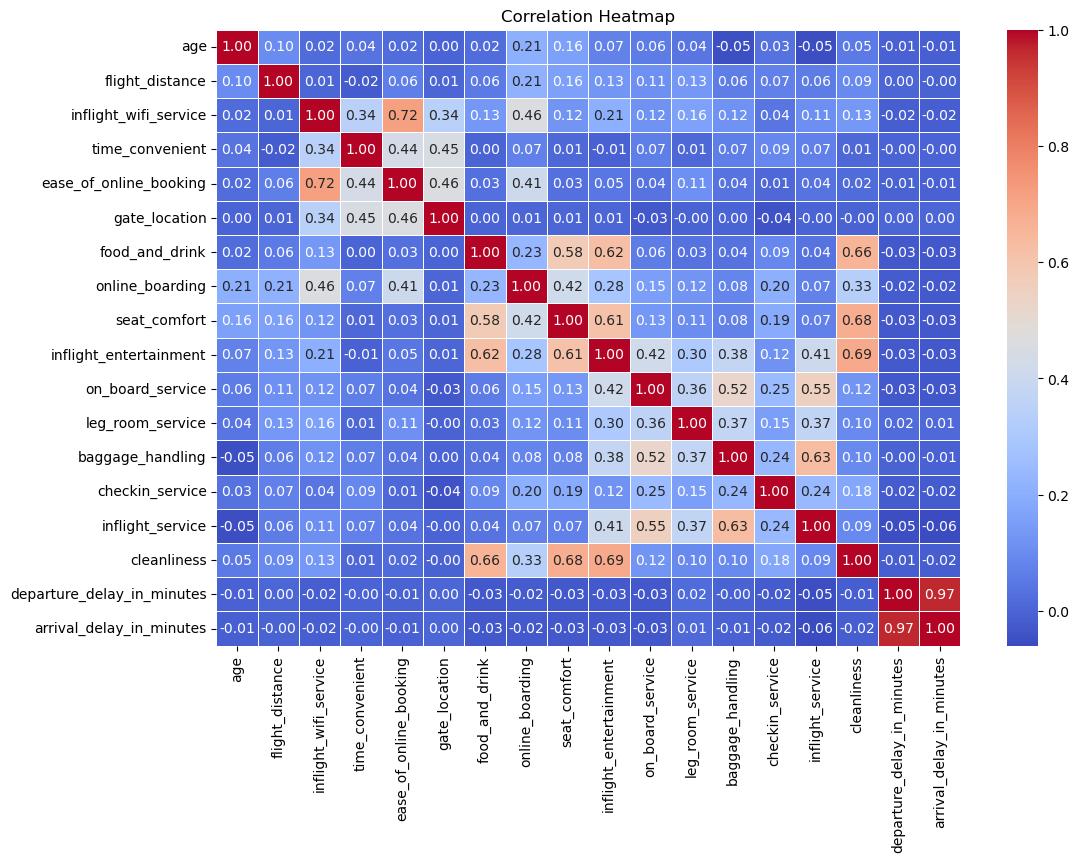

In [26]:
# Correlation matrix
numeric_data = train_data.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Some features have high correlation suggesting multicollinearity. Departure Delay in Minutes vs. Arrival Delay in Minutes are very high correlated features (anomalous correlation, which suggests they both contain the same information, so one of them can be deleted). 

### Checking for correlations between dependent and independent variables 

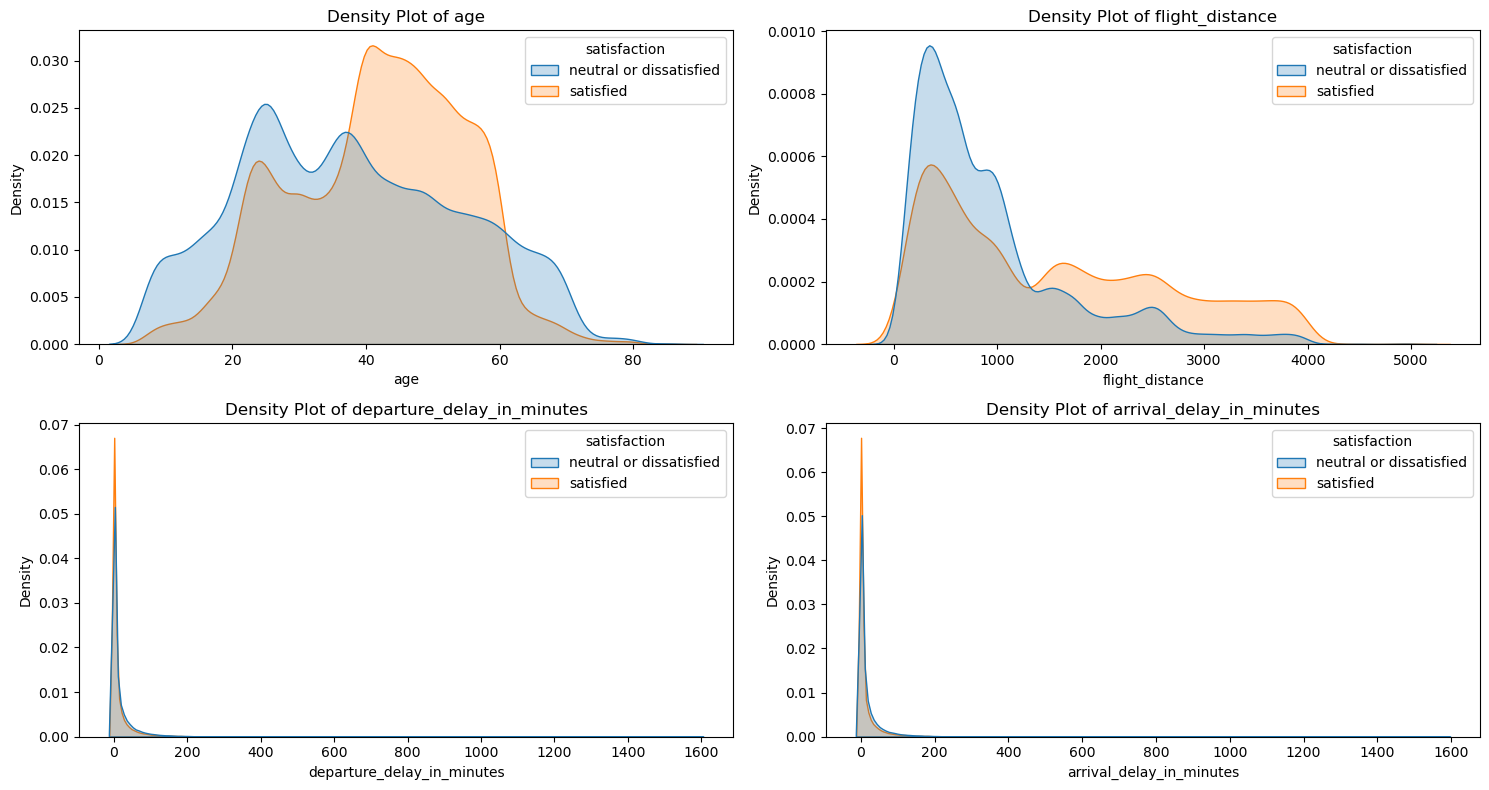

In [32]:
# Get the numeric columns
numeric_columns = ['age', 'flight_distance', 'departure_delay_in_minutes', 'arrival_delay_in_minutes']
n_cols = 2
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols  

# Plot the density plot
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.kdeplot(data=train_data, x=column, hue="satisfaction", fill=True, ax=axes[i], common_norm=False)
    axes[i].set_title(f'Density Plot of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Density')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

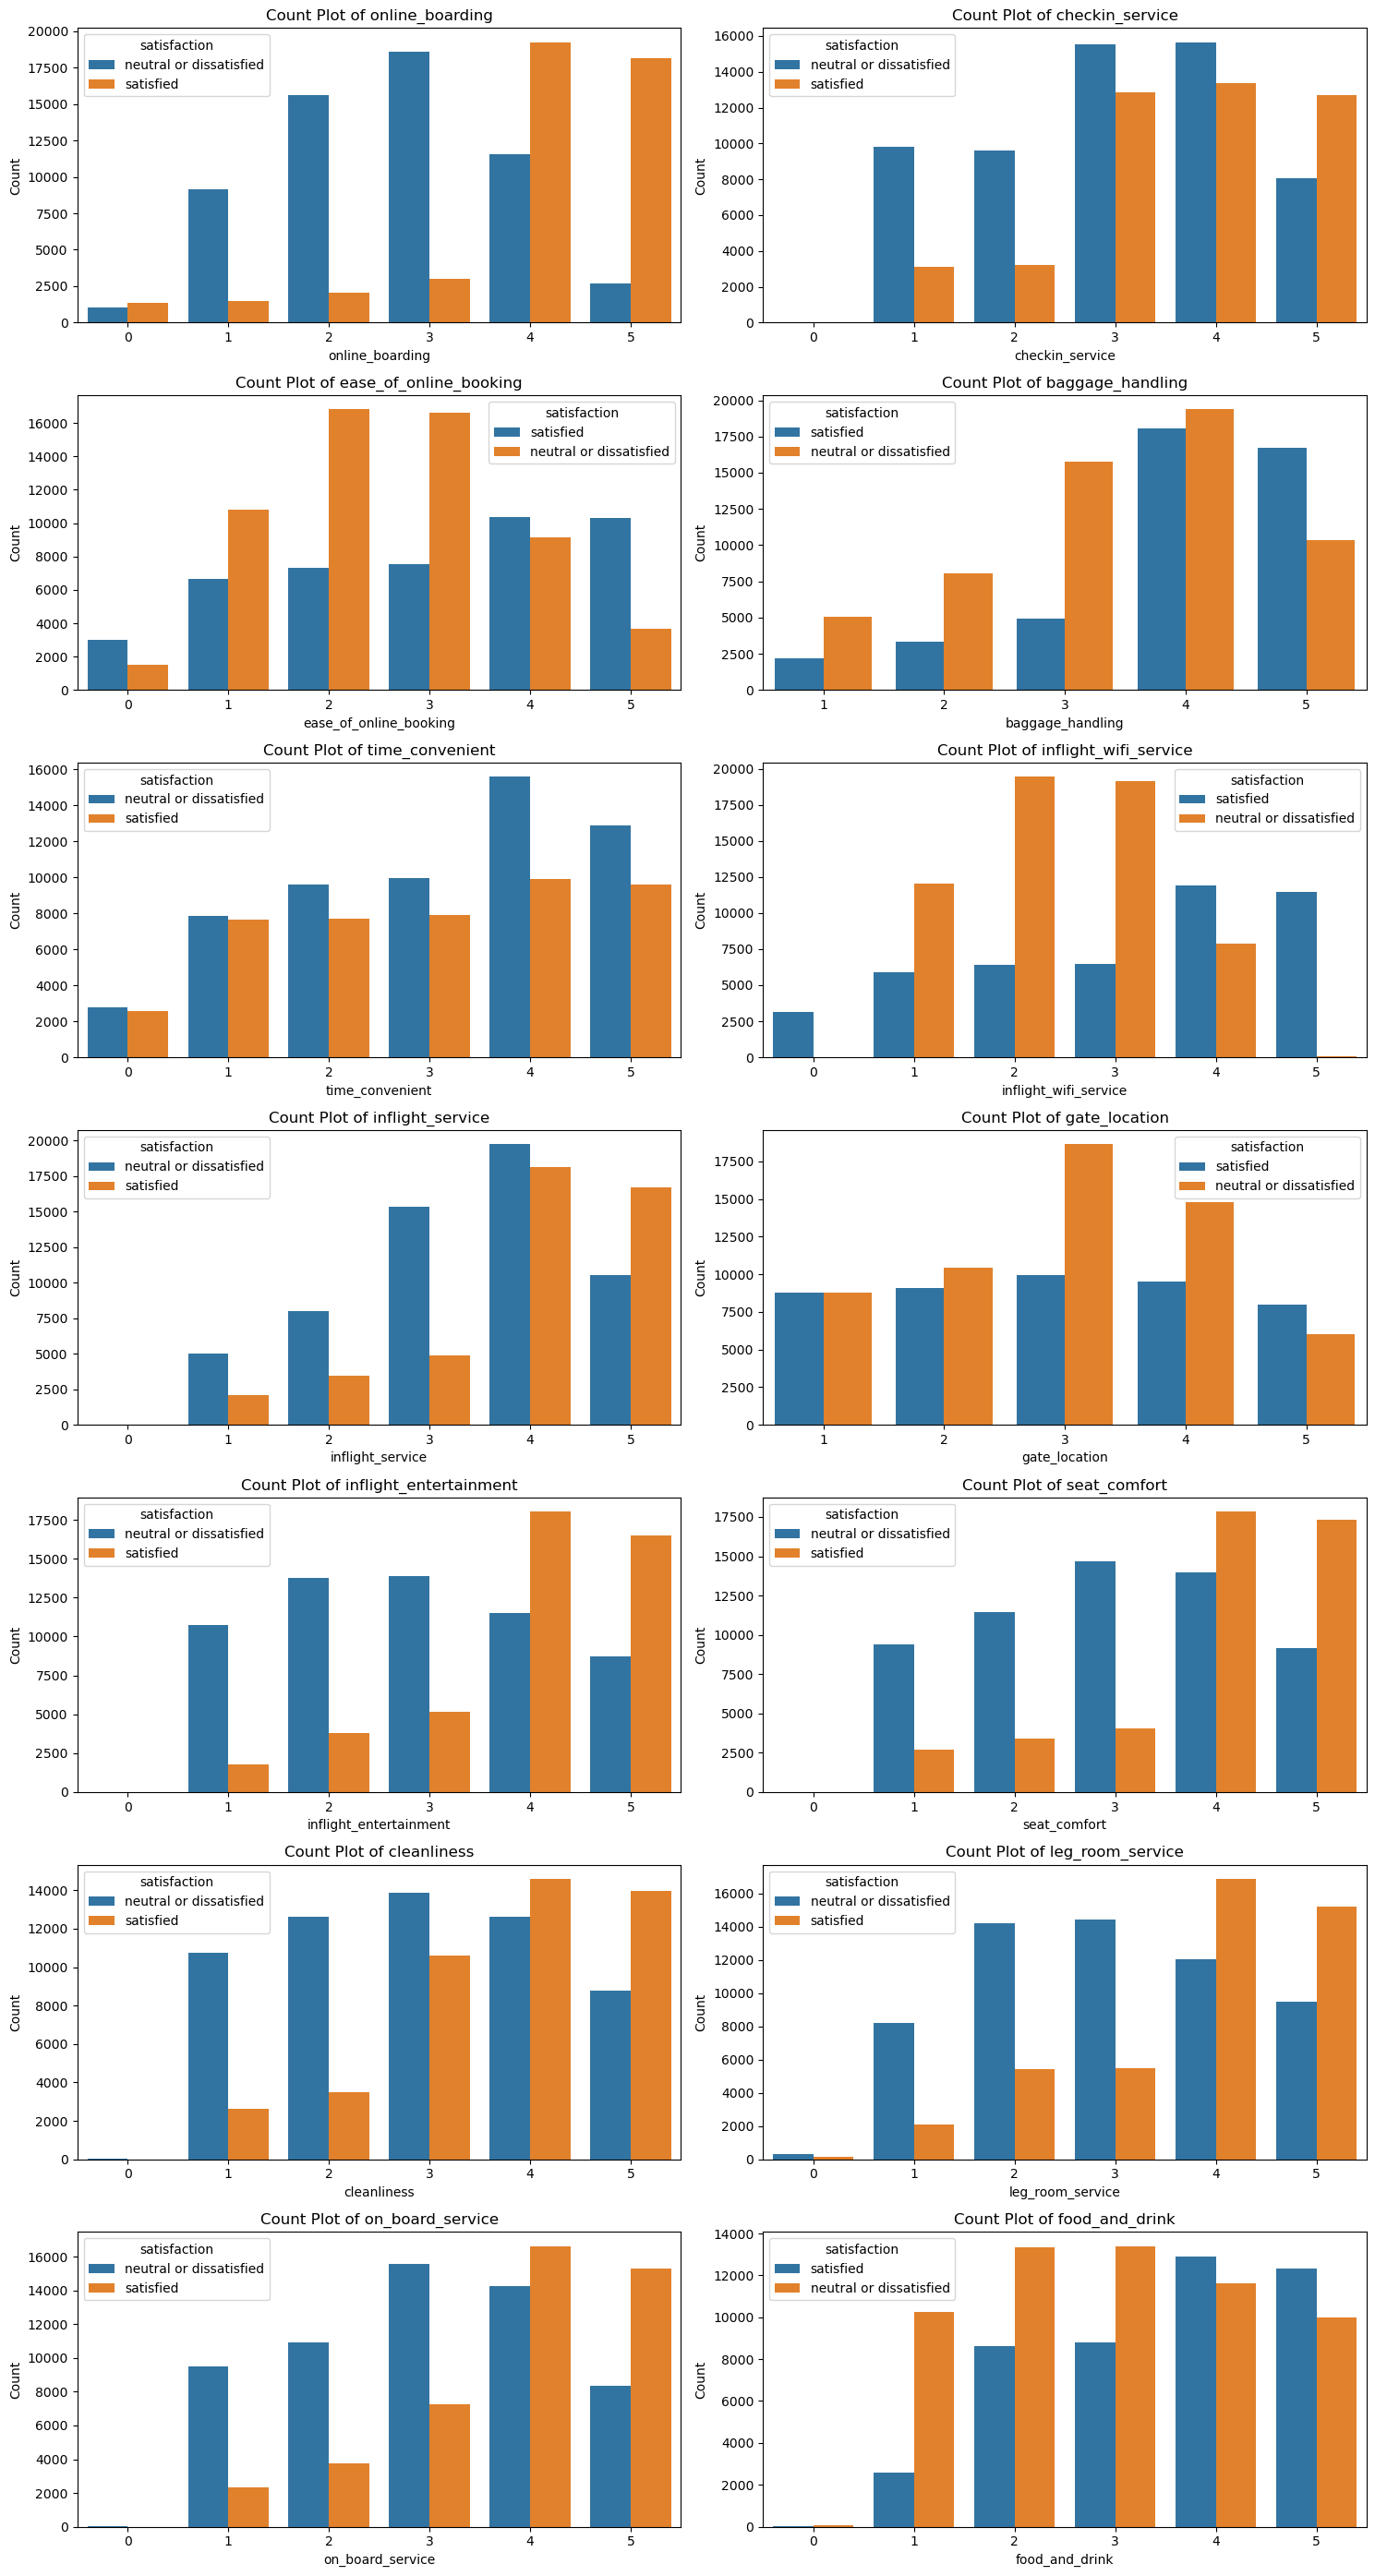

In [36]:
# Get the ordinal columns
ordinal_cols = list(set(train_data.select_dtypes(include=['number']).columns) - set(numeric_columns))
n_cols = 2
n_rows = (len(ordinal_cols) + n_cols - 1) // n_cols  


fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, column in enumerate(ordinal_cols):
    sns.countplot(data=train_data, x=column, hue='satisfaction', ax=axes[i])
    axes[i].set_title(f'Count Plot of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')  

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

We can see that there is no such feature that has very high correlation with the target variable. Meaning, there is no feature that will provide near 100% separation between the classes.

### Missing Values

There were missing values in the column `arrival_delay_in_minutes`. Since, it is very correlated to `departure_delay_in_minutes` we decided to remove it and get rid of the missing values as well.

## Preprocessing Steps for the Airline Passenger Satisfaction Dataset

### 1. Removing the `arrival_delay_in_minutes` feature
The feature has both missing values and very high correlation with `departure_delay_in_minutes` feature. 

### 2. Encoding Categorical Variables
Categorical columns like `gender`, `type_of_travel`, `class`, `satisfaction`, and others will need to be encoded:

- `satisfaction` will be encoded as a binary variable (**0** for "Dissatisfied", **1** for "Satisfied").
- Other categorical variables will be encoded using **one-hot encoding**, where applicable.

### 3. Scaling Numerical Features
We need to **standardize** or **scale** numerical features like `age`, `flight_distance`, `seat_comfort`, `inflight_wifi_service`, etc., so that they all have similar scales. This will help avoid dominance of variables with larger ranges.


In [25]:
X_train = train_data.drop(['satisfaction'], axis=1)  
y_train = train_data['satisfaction']

In [28]:
categorical_cols = ['gender', 'customer_type', 'type_of_travel', 'class']

ordinal_cols = ['inflight_wifi_service', 'time_convenient', 'ease_of_online_booking', 
                'gate_location', 'food_and_drink', 'online_boarding', 'seat_comfort', 
                'inflight_entertainment', 'on_board_service', 'leg_room_service',
               'baggage_handling', 'checkin_service', 'inflight_service', 'cleanliness']


numerical_cols = ['age', 'flight_distance', 'departure_delay_in_minutes']

drop_cols = ['arrival_delay_in_minutes']

assert len(categorical_cols + ordinal_cols + numerical_cols + drop_cols) == len(X_train.columns), \
"The sum of the number of columns in the categorical_cols, ordinal_cols and numerical cols is not equal to the number of columns in train data"

preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    (MinMaxScaler(), ordinal_cols),
    (StandardScaler(), numerical_cols),
    ('drop', drop_cols)
)

preprocessor

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['gender', 'customer_type', 'type_of_travel',
                                  'class']),
                                ('minmaxscaler', MinMaxScaler(),
                                 ['inflight_wifi_service', 'time_convenient',
                                  'ease_of_online_booking', 'gate_location',
                                  'food_and_drink', 'online_boarding',
                                  'seat_comfort', 'inflight_entertainment',
                                  'on_board_service', 'leg_room_service',
                                  'baggage_handling', 'checkin_service',
                                  'inflight_service', 'cleanliness']),
                                ('standardscaler', StandardScaler(),
                                 ['age', 'flight_distance',
                                  'departure_delay_in_minutes']),
                                ('drop', 'drop', ['arrival_delay_in_minutes'])])

## Modelling

Our problem is a binary classification problem.  
We will use scikit-learn library for training machine learning models (Pedregosa, 2021)

### Base Model

Our baseline model is the **DummyClassifier**, which predicts the majority class. This serves as a reference point for evaluating the performance of other models. Any model we implement should demonstrate performance that surpasses this baseline to be considered effective.

In [29]:
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=123)
dummy_results = pd.DataFrame(cross_validate(dummy_clf, X_train, y_train, return_train_score=True))

In [30]:
dummy_results

,fit_time,score_time,test_score,train_score
0,0.044436,0.040260,0.564362,0.564332
1,0.050215,0.052058,0.564362,0.564332
2,0.046849,0.031195,0.564314,0.564344
3,0.046874,0.031253,0.564314,0.564344
4,0.046872,0.031250,0.564341,0.564338


The base model has a validation accuracy of approximately 56.4% (accuracy is the percentage of correct predictions and the default classification metric) which corresponds to the percentage of the majority class in the dataset.

### Comparison Model(s)

With the comparison models we aim to outperform the base models. Let's start with **Logistic Regression**😺

In [31]:
log_clf = make_pipeline(preprocessor, LogisticRegression(random_state=123))
log_results = pd.DataFrame(cross_validate(
    log_clf, 
    X_train, 
    y_train, 
    return_train_score=True
)).rename(columns={'test_score': 'validation_score'})

In [32]:
log_results

,fit_time,score_time,validation_score,train_score
0,0.388908,0.046926,0.871806,0.874872
1,0.339930,0.062564,0.876474,0.873609
2,0.328063,0.046922,0.877147,0.873260
3,0.329406,0.046930,0.870410,0.874968
4,0.328097,0.046933,0.874062,0.874549


The **Logistic Regression** Model greatly outperforms the base model. It generates train and validation with approximately 87% accuracy. This is a significant improvement from the 56.4% accuracy. 
However, since we had a small imbalance in our dataset, it is better to consider other metrics such as recall, precision and F1-Score.

Below we also consider other models and report **different scoring metrics** for the models.

In [33]:
models = {
    "dummy": DummyClassifier(random_state=123), 
    "Logistic Regression": LogisticRegression(random_state=123),
    "Decision Tree": DecisionTreeClassifier(random_state=123),
}

scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': 'recall_weighted',
    'f1': make_scorer(f1_score, average='weighted')
}

In [34]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    pipe = make_pipeline(preprocessor, model)
    scores = cross_validate(pipe, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [35]:
results_df = {}

for name, estimator in models.items():
    scores = mean_std_cross_val_scores(estimator,
                                       X_train, y_train, 
                                       return_train_score=True,
                                       scoring=scoring)
    results_df[name] = scores
    
results_df = pd.DataFrame(results_df).T
results_df.rename(columns={
    'test_accuracy': 'validation_accuracy',
    'test_precision': 'validation_precision',
    'test_recall': 'validation_recall',
    'test_f1': 'validation_f1'
}, inplace=True)

In [36]:
results_df

,fit_time,score_time,validation_accuracy,train_accuracy,validation_precision,train_precision,validation_recall,train_recall,validation_f1,train_f1
dummy,0.134 (+/- 0.011),0.472 (+/- 0.017),0.564 (+/- 0.000),0.564 (+/- 0.000),0.318 (+/- 0.000),0.318 (+/- 0.000),0.564 (+/- 0.000),0.564 (+/- 0.000),0.407 (+/- 0.000),0.407 (+/- 0.000)
Logistic Regression,0.338 (+/- 0.015),0.475 (+/- 0.025),0.874 (+/- 0.003),0.874 (+/- 0.001),0.874 (+/- 0.003),0.874 (+/- 0.001),0.874 (+/- 0.003),0.874 (+/- 0.001),0.874 (+/- 0.003),0.874 (+/- 0.001)
Decision Tree,0.519 (+/- 0.024),0.489 (+/- 0.020),0.945 (+/- 0.001),1.000 (+/- 0.000),0.946 (+/- 0.001),1.000 (+/- 0.000),0.945 (+/- 0.001),1.000 (+/- 0.000),0.945 (+/- 0.001),1.000 (+/- 0.000)


Based on the findings, we determined that **Decision Tree** a **better model** to utilize since it provides the highest score on all metrics on the validation data. While it has a degree of overfitting, the score is a lot higher than of logistic regression. We can further tune the hyperparameters using Grid Search to reduce the overfitting and still have good results.

Logistic Regression, on the other hand, is a linear model and we can't improve it further (unless we introduce polynomial terms). Since decision trees is both a complex model and can be interpreted easily, we decide to move forward with decision trees and tune the max_depth parameter to reduce overfitting and improve overall performance.

### Grid Search

In [37]:
param_grid = {
    'decisiontreeclassifier__max_depth': [10, 12, 15, 18],  
}

In [38]:
dt_pipe = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=123))

grid_search = GridSearchCV(
    estimator=dt_pipe,
    param_grid=param_grid,
    scoring='accuracy',  
    cv=5,  
    n_jobs=-1,  
    return_train_score=True 
)

In [39]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['gender',
                                                                          'customer_type',
                                                                          'type_of_travel',
                                                                          'class']),
                                                                        ('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         ['inflight_wifi_service',
                                                                          'time_convenient',
                                                                          'ease_of_online_booking',
                                                                          'gate_location',
                                                                          'food_and_drink',
                                                                          'online_boar...
                                                                          'inflight_service',
                                                                          'cleanliness']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'flight_distance',
                                                                          'departure_delay_in_minutes']),
                                                                        ('drop',
                                                                         'drop',
                                                                         ['arrival_delay_in_minutes'])])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=123))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': [10, 12, 15, 18]},
             return_train_score=True, scoring='accuracy')

In [40]:
mean_train_scores = grid_search.cv_results_['mean_train_score']
std_train_scores = grid_search.cv_results_['std_train_score']
mean_validation_scores = grid_search.cv_results_['mean_test_score']
std_validation_scores = grid_search.cv_results_['std_test_score']

print("Scores for each hyperparameter combination:")
for params, mean_train, std_train, mean_val, std_val in zip(
    grid_search.cv_results_['params'], mean_train_scores, std_train_scores, mean_validation_scores, std_validation_scores
):
    print(
        f"Parameters: {params}, "
        f"Mean Train Score: {mean_train:.4f} (+/- {std_train:.4f}), "
        f"Mean Validation Score: {mean_val:.4f} (+/- {std_val:.4f})"
    )

print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

Scores for each hyperparameter combination:
Parameters: {'decisiontreeclassifier__max_depth': 10}, Mean Train Score: 0.9505 (+/- 0.0008), Mean Validation Score: 0.9455 (+/- 0.0017)
Parameters: {'decisiontreeclassifier__max_depth': 12}, Mean Train Score: 0.9618 (+/- 0.0005), Mean Validation Score: 0.9511 (+/- 0.0014)
Parameters: {'decisiontreeclassifier__max_depth': 15}, Mean Train Score: 0.9743 (+/- 0.0007), Mean Validation Score: 0.9520 (+/- 0.0008)
Parameters: {'decisiontreeclassifier__max_depth': 18}, Mean Train Score: 0.9841 (+/- 0.0007), Mean Validation Score: 0.9510 (+/- 0.0013)

Best parameters: {'decisiontreeclassifier__max_depth': 15}
Best cross-validation accuracy: 0.9520037872382778


# Reporting performance

🔔 Time to evaluate our model on unseen data！

In [41]:
# Prepare the test set
X_test = test_data.drop(columns=['satisfaction'])
y_test = test_data['satisfaction']
y_test = y_test.values.ravel()

# Get the best estimator from the grid search
final_model = grid_search.best_estimator_

# Predict on the test set
y_test_pred = final_model.predict(X_test)

### Classification Report
We can see that decision tree worked well on the validation data. Below we test the model on unseen data and check metrics like accuracy, recall, precision and F1-Score. Additionally, the consistency of macro-average and weighted-average scores will demonstrate the model's ability to efficiently handle slightly skewed class distributions, demonstrating its stability, generalization capabilities, and dependability as an efficient classification model.

In [42]:
from sklearn.metrics import accuracy_score, classification_report

print("Decision Tree Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

Decision Tree Test Accuracy: 0.9525331074838312

Classification Report:
                          precision    recall  f1-score   support

neutral or dissatisfied       0.95      0.97      0.96     14815
              satisfied       0.96      0.93      0.94     11161

               accuracy                           0.95     25976
              macro avg       0.95      0.95      0.95     25976
           weighted avg       0.95      0.95      0.95     25976



##### Confusion Matrix 

Positive class - "neutral or dissatisfied"
Negative class - "satisfied"

The matrix below shows that the model performs well overall, correctly predicting 14,362 "neutral or dissatisfied" and 10,381 "satisfied" samples. There were 780 false positives where "satisfied" samples were misclassified as "neutral or dissatisfied" and 453 false positives where "neutral or dissatisfied" samples were misclassified as "satisfied." This implies that the model has a higher recall for "Neutral or Dissatisfied" (97%) than for "Satisfied" (93%), indicating a little bias toward the former. While the model is effective, raising the recall for "Dissatisfied" by adjusting the decision threshold or rebalancing the data may enhance its performance.

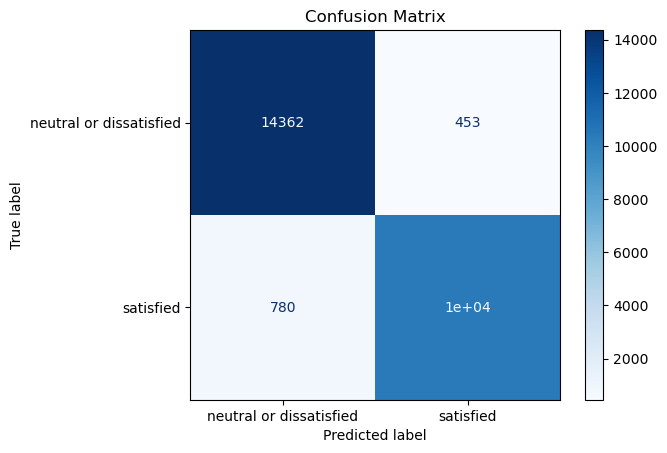

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

### Precision-Recall
The Precision-Recall curve is quite smooth, with both Precision and Recall consistently above 0.9 in most cases. Overall the model's predictions are quite consistent across the classes. 

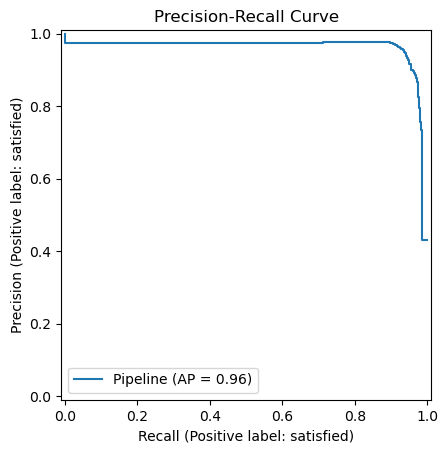

In [44]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(
    estimator=final_model,  
    X=X_test,               
    y=y_test,              
    pos_label='satisfied', 
)
plt.title("Precision-Recall Curve")
plt.show()

### ROC Curve
As we know a perfect AUC score is 1.0, our AUC value of 0.98 indicates that the model performs exceptionally well in distinguishing between the positive ("satisfied") and negative ("neutral or dissatisfied") classes.

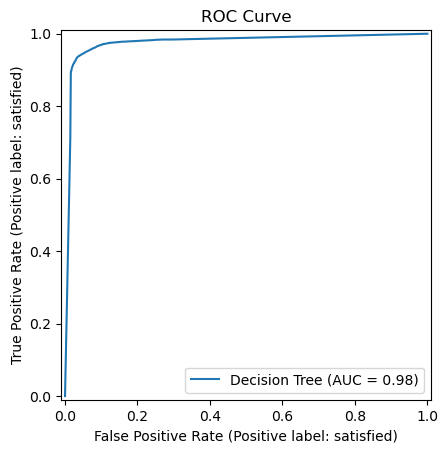

In [45]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_estimator(
    estimator=final_model,  
    X=X_test,              
    y=y_test,               
    name="Decision Tree",  
    pos_label="satisfied"       
)
plt.title("ROC Curve")
plt.show()


# Discussion
The results are close to what we expected to see. Our model can be successfully used in predicting US airline satisfaction providing reliable insights.

While the model demonstrates that it is possible to predict customer satisfaction with high accuracy, there are few directions that could be explored to improve it further.  

First, we can compare the wrong predictions from the confusion matrix with the correctly classified data. This could help determine which features are causing misclassifications and whether feature engineering can improve the model. Experimenting with various classifiers, such as Random Forest or Gradient Boosting Machines, and making other hyperparameter tweaks may also increase performance. For example, tuning other hyperparameters such as `min_samples_split`, `min_samples_leaf`, etc. 

Also, we'd like to determine which specific attributes most strongly drive satisfaction or dissatisfaction. While the existing model is effective at categorization, it does not explain why customers are pleased or unsatisfied. To solve this, we may employ interpretability approaches like SHAP or LIME to determine how particular attributes contribute to model predictions. 

Furthermore, experimental approaches like A/B testing can provide causal insights into how particular variables, such as service quality or flight delays, impact satisfaction.

# References

M. Sadegh Eshaghi, Mona Afshardoost, Gui Lohmann, Brent D Moyle, Drivers and outcomes of airline passenger satisfaction: A Meta-analysis, Journal of the Air Transport Research Society, Volume 3, 2024, 100034, ISSN 2941-198X, https://doi.org/10.1016/j.jatrs.2024.100034.

Namukasa, J. (2013), "The influence of airline service quality on passenger satisfaction and loyalty : The case of Uganda airline industry", The TQM Journal, Vol. 25 No. 5, pp. 520-532. https://doi.org/10.1108/TQM-11-2012-0092

TJ, Klein. (2020, February). "Airline Passenger Satisfaction". Retrieved November 20, 2024 from Kaggle Dataset.

Pedregosa, F. et al., 2011. Scikit-learn: Machine learning in Python. Journal of machine learning research, 12(Oct), pp.2825–2830.

McKinney, Wes. 2010. “Data Structures for Statistical Computing in Python.” In Proceedings of the 9th Python in Science Conference, edited by Stéfan van der Walt and Jarrod Millman, 51–56.